In [1]:
### Importing the required modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### Reading the data

happiness_data = pd.read_csv("ACME-HappinessSurvey2020.csv")
happiness_data.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [3]:
### To see if there is class imbalance

happiness_data['Y'].value_counts()

Y
1    69
0    57
Name: count, dtype: int64

In [4]:
### Looking if there are any missing values and the data types

happiness_data.info()
happiness_data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64

In [5]:
### Segeregating the outputs and the inputs for the ML model

labels = happiness_data['Y']
X_data = happiness_data.drop('Y', axis=1)

In [6]:
### Renaming the columns for interpretability

X_data.columns=['Timely delivery','Order content expectations','Content variety','Value for money','Order satisfaction','Easy app interface']

In [7]:
sns.set() ### To set the plot background types for seaborn library

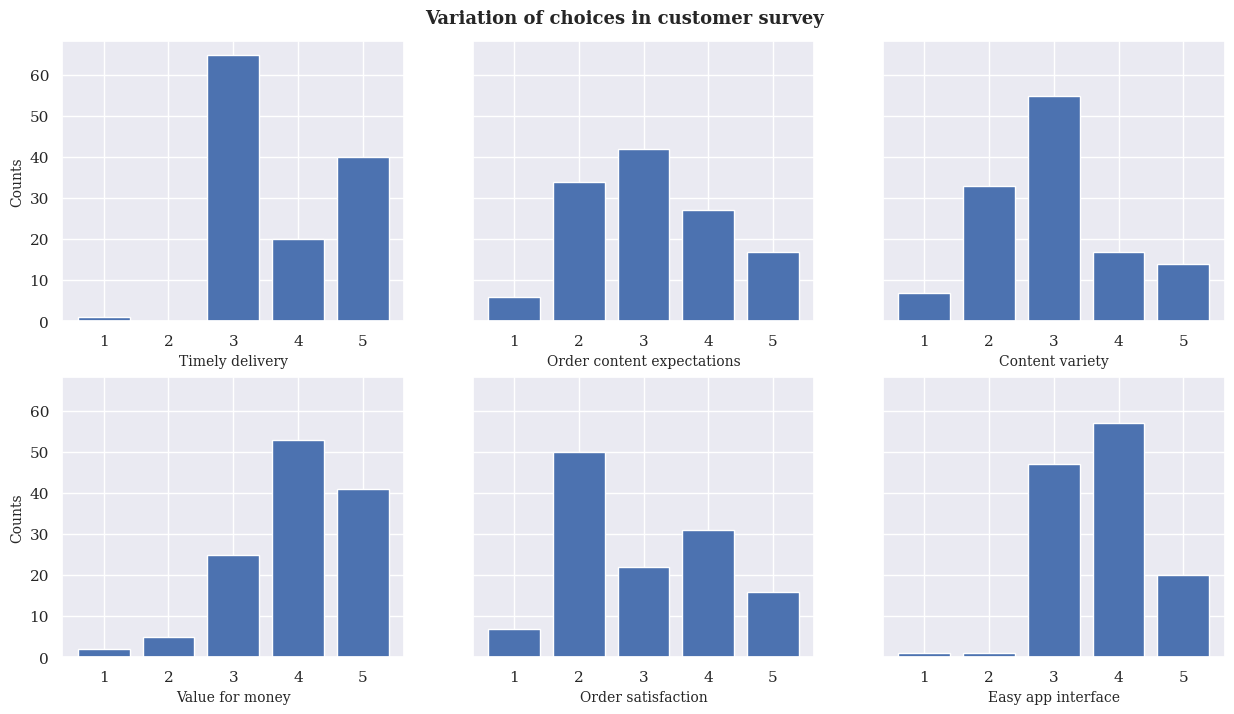

In [8]:
num_rows = 2
num_cols = 3
plt.rcParams["font.family"]="serif"
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharey=True, figsize=[15,8])
for i in range(num_rows):
    for j in range(num_cols):
        var = X_data.columns[j + i * num_cols]
        axes[i,j].bar(height = X_data[var].value_counts(), x = X_data[var].unique())
        axes[i,j].set_xlabel(var, fontsize=10)
        if (j==0):
            axes[i,j].set_ylabel('Counts', fontsize=10)

fig.suptitle("Variation of choices in customer survey", fontweight='bold', fontsize=13, y=0.92)
plt.tight_layout
plt.show()

### Trying to see if there is any correlation between the different ordinal variables. For this, the Spearman correlation $\rho$ coefficients are computed.

$\rho$ = 1 - 6$\sum d_{i}^2$ / $(n(n^2-1))$

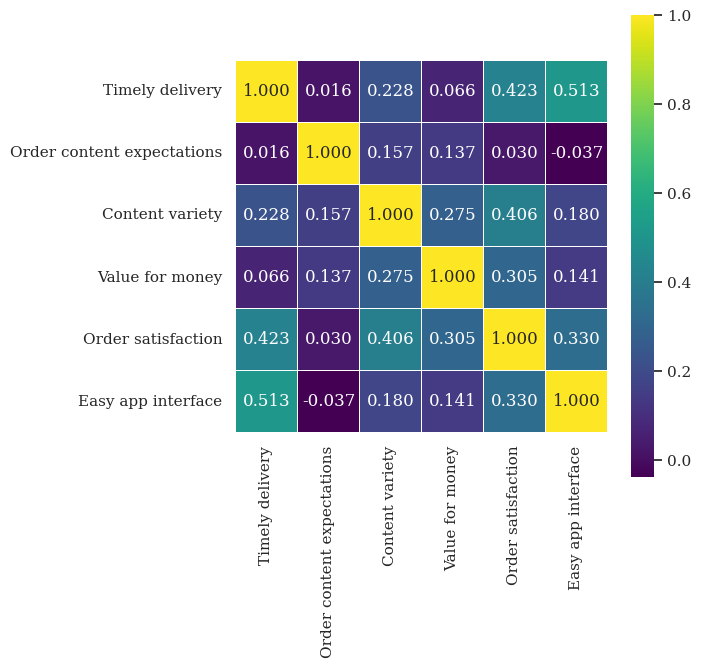

In [9]:
from scipy.stats import spearmanr

spearman_matrix = X_data.corr(method='spearman')
plt.figure(figsize=[6,6])
heatmap = sns.heatmap(spearman_matrix, annot=True, cmap = 'viridis', linewidths=0.5, square=True, fmt = '.3f')
plt.show()

In [10]:
### Investigating the correlation between the input variables and the output variable

target_correlations = {}
for col in X_data.columns:
    corr, p_value = spearmanr(X_data[col], labels)
    target_correlations[col] = {'correlation': corr, 'p_value': p_value}

corr_df = pd.DataFrame(target_correlations).T
print("Spearman correlations with target:")
print(corr_df.sort_values('correlation', key=abs, ascending=False))

Spearman correlations with target:
                            correlation   p_value
Timely delivery                0.291458  0.000929
Order satisfaction             0.227306  0.010477
Easy app interface             0.174114  0.051191
Content variety                0.162199  0.069590
Value for money                0.081398  0.364889
Order content expectations    -0.034304  0.702950


### ML Models

In [11]:
### The classes are imbalanced, setting the class weights to be balanced for different models
### For logistic regression or decision trees, using "compute_class_weight"
### For XGBoost model, using "compute_sample_weight"

from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
classes = np.unique(labels)
computed_class_weights = compute_class_weight('balanced', classes=classes, y = labels)
class_weight_dict = dict(zip(classes, computed_class_weights))

sample_weights = compute_sample_weight('balanced', labels)

In [12]:
### Decision trees and XGBoost will not require scaling.
### The ordinal variables though have the same range, will profit due to scaling for applying regularization and the algorithm themselves,
### for example during use in neural networks.

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

standard_scaler = StandardScaler()
minmaxscaler = MinMaxScaler()

x_train, x_val, y_train, y_val = train_test_split(X_data, labels, test_size = 0.25, random_state=28)
x_train_scaled = standard_scaler.fit_transform(x_train)
x_val_scaled = standard_scaler.transform(x_val)

The accuracy score is: 0.5
The precision score is: 0.71
The recall score is: 0.52
The f1 score is: 0.6


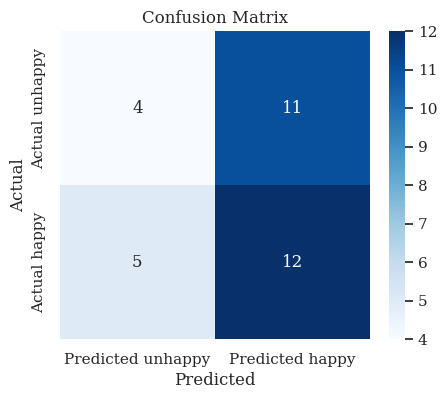

In [13]:
### An untuned logistic regression model will be chosen as the baseline model.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

logreg = LogisticRegression(class_weight=class_weight_dict, random_state=28)
logreg.fit(x_train_scaled, y_train)

y_pred = logreg.predict(x_val_scaled)

print(f'The accuracy score is: {round(accuracy_score(y_pred, y_val),2)}')
print(f'The precision score is: {round(precision_score(y_pred, y_val),2)}')
print(f'The recall score is: {round(recall_score(y_pred, y_val),2)}')
print(f'The f1 score is: {round(f1_score(y_pred, y_val),2)}')

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted unhappy', 'Predicted happy'],
            yticklabels=['Actual unhappy', 'Actual happy'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [14]:
from scipy.stats import loguniform

def model_investigation(model, param_grid, xt, yt, xv, yv, n_iter=10):
    
    classifier = model
    parameter_grid = param_grid
    
    from scipy.stats import uniform

    cv_to_choose = np.linspace(2, 16, num=8).astype(int)
    val_scores = []
    best_score = 0
    best_model = None
    best_params= None
    precision= 0
    recall = 0
    f1 = 0
    best_preds = None
    best_fold = None
    
    for i in range(len(cv_to_choose)):
        grid_search = RandomizedSearchCV(
            estimator=classifier,
            param_distributions=parameter_grid,
            cv=StratifiedKFold(n_splits=cv_to_choose[i], shuffle=True, random_state=28),
            verbose=1,
            scoring = 'accuracy',
            n_iter=n_iter)

        grid_search.fit(xt, yt)
        
        ### Trying to see if there is overfitting in the grid search process
        training_score = round(grid_search.score(xt,yt), 2)
        print(f"The training set score for cv = {cv_to_choose[i]} is: {training_score}")
        print(f'The difference between train and CV score for cv = {cv_to_choose[i]} is: {round(abs(grid_search.best_score_ - training_score),2)}\n')
        
        model_cv = grid_search.best_estimator_
        y_pred_cv = model_cv.predict(xv)
        val_scores.append(round(accuracy_score(y_pred_cv, yv),2))
        
        accuracy = accuracy_score(y_pred_cv, yv)
        if accuracy > best_score:
            best_score = accuracy
            best_model = model_cv
            best_params = grid_search.best_params_
            precision = precision_score(y_pred_cv, yv)
            recall = recall_score(y_pred_cv, yv)
            f1 = f1_score(y_pred_cv, yv)
            best_preds = y_pred_cv
            best_fold = cv_to_choose[i]
    
    print(f'For algorithm {model}:')
    print(f"The best model parameters are: {best_params}")
    print(f'The associated accuracy score is: {round(best_score,2)}')
    print(f'The associated precision score is: {round(precision,2)}')
    print(f'The associated recall score is: {round(recall,2)}')
    print(f'The associated f1 score is: {round(f1,2)}\n')
    print(f'The associated cross validation folds are: {best_fold}\n')

    cm = confusion_matrix(yv, best_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted unhappy', 'Predicted happy'],
            yticklabels=['Actual unhappy', 'Actual happy'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()    

    plt.figure()    
    plt.plot(cv_to_choose, val_scores, marker = '^', mfc = 'red', mec = 'k')
    plt.xlabel('Number of cross-validation folds')
    plt.ylabel('Accuracies on the validation set')
    plt.show()
    
    return best_model

Fitting 2 folds for each of 200 candidates, totalling 400 fits
The training set score for cv = 2 is: 0.64
The difference between train and CV score for cv = 2 is: 0.01

Fitting 4 folds for each of 200 candidates, totalling 800 fits
The training set score for cv = 4 is: 0.63
The difference between train and CV score for cv = 4 is: 0.01

Fitting 6 folds for each of 200 candidates, totalling 1200 fits
The training set score for cv = 6 is: 0.63
The difference between train and CV score for cv = 6 is: 0.0

Fitting 8 folds for each of 200 candidates, totalling 1600 fits
The training set score for cv = 8 is: 0.63
The difference between train and CV score for cv = 8 is: 0.01

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
The training set score for cv = 10 is: 0.63
The difference between train and CV score for cv = 10 is: 0.0

Fitting 12 folds for each of 200 candidates, totalling 2400 fits
The training set score for cv = 12 is: 0.63
The difference between train and CV score 

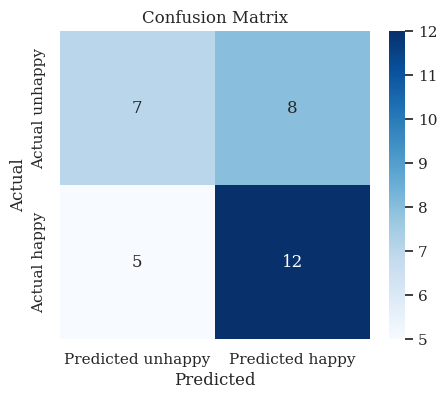

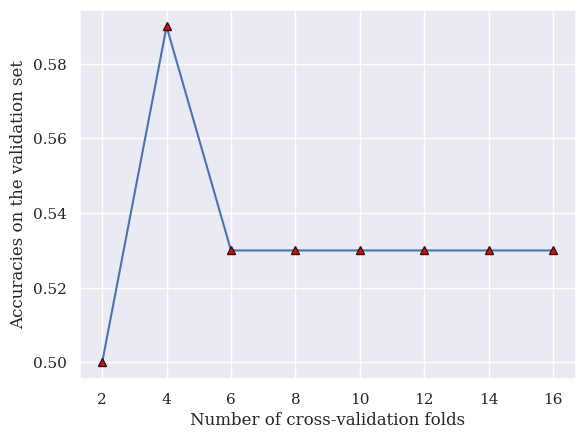

In [15]:
### As the next step, a tuned model will be tried out.
### For this, a grid serach of hyperparameters will be carried out.

from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

logreg_model = LogisticRegression(class_weight=class_weight_dict, random_state=28)
grid_search_params = {'penalty': ['l1','l2'],
                     'solver': ['liblinear'],
                     'C':loguniform(1e-4,1e2)}
best_logreg_model = model_investigation(logreg_model, grid_search_params, x_train_scaled, y_train, x_val_scaled, y_val, 200)

Fitting 2 folds for each of 30 candidates, totalling 60 fits
The training set score for cv = 2 is: 0.9
The difference between train and CV score for cv = 2 is: 0.25

Fitting 4 folds for each of 30 candidates, totalling 120 fits
The training set score for cv = 4 is: 0.93
The difference between train and CV score for cv = 4 is: 0.26

Fitting 6 folds for each of 30 candidates, totalling 180 fits
The training set score for cv = 6 is: 0.93
The difference between train and CV score for cv = 6 is: 0.23

Fitting 8 folds for each of 30 candidates, totalling 240 fits
The training set score for cv = 8 is: 0.84
The difference between train and CV score for cv = 8 is: 0.18

Fitting 10 folds for each of 30 candidates, totalling 300 fits
The training set score for cv = 10 is: 0.87
The difference between train and CV score for cv = 10 is: 0.19

Fitting 12 folds for each of 30 candidates, totalling 360 fits
The training set score for cv = 12 is: 0.86
The difference between train and CV score for cv = 1

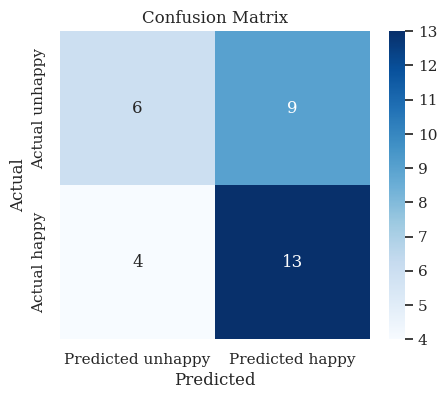

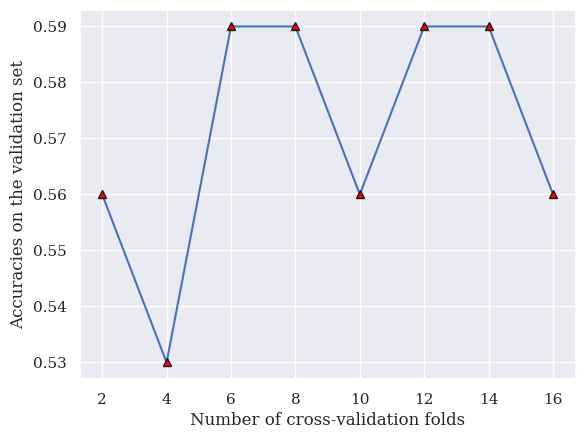

In [16]:
### Now, will try an ensemble model(RandomForests) and use a tuned version of it.
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)
grid_search_params = {'n_estimators' : [100, 150, 200, 300],
                     'max_depth': [3,5,7,None],
                     'class_weight': ['balanced'],
                      'max_samples':[0.5,0.6,0.7,0.8,0.9],
                      'max_features': ['sqrt','log2'],
                     'random_state':[28],
                     'oob_score':[True, False]}
best_rf_model = model_investigation(rfc, grid_search_params, x_train_scaled, y_train, x_val_scaled, y_val, 30)

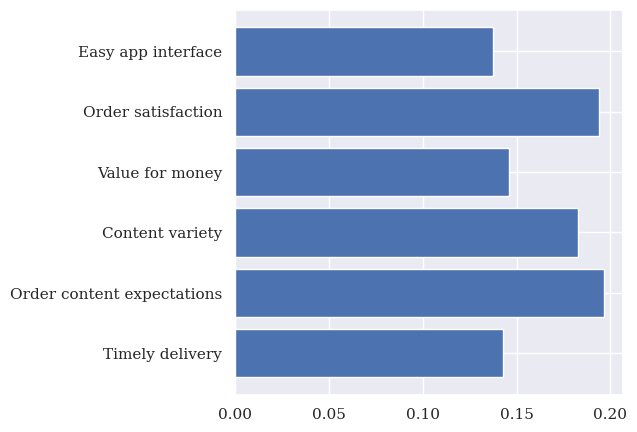

In [18]:
feats_rf = best_rf_model.feature_importances_
features = X_data.columns

plt.figure(figsize=(5,5))
plt.barh(y=features, width=feats_rf)
plt.show()

Fitting 2 folds for each of 200 candidates, totalling 400 fits
The training set score for cv = 2 is: 0.82
The difference between train and CV score for cv = 2 is: 0.14

Fitting 4 folds for each of 200 candidates, totalling 800 fits
The training set score for cv = 4 is: 0.73
The difference between train and CV score for cv = 4 is: 0.02

Fitting 6 folds for each of 200 candidates, totalling 1200 fits
The training set score for cv = 6 is: 0.77
The difference between train and CV score for cv = 6 is: 0.01

Fitting 8 folds for each of 200 candidates, totalling 1600 fits
The training set score for cv = 8 is: 0.84
The difference between train and CV score for cv = 8 is: 0.17

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
The training set score for cv = 10 is: 0.77
The difference between train and CV score for cv = 10 is: 0.08

Fitting 12 folds for each of 200 candidates, totalling 2400 fits
The training set score for cv = 12 is: 0.78
The difference between train and CV scor

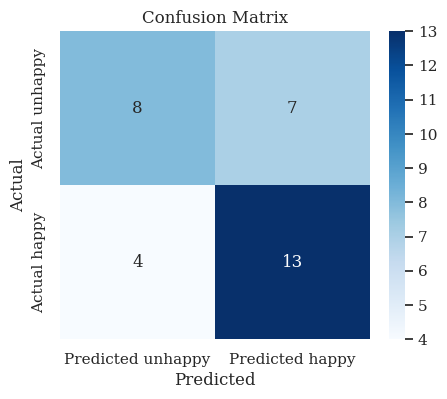

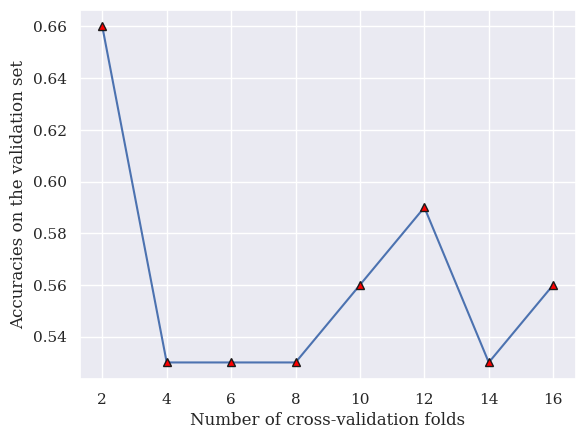

In [28]:
### As our next effort, we are going to try the XGBoost model after hyperparameter tuning
from xgboost import XGBClassifier
from scipy.stats import uniform

xgb_classifier = XGBClassifier(objective='binary:logistic',random_state=42,n_jobs=4)

parameter_grid = {
        'n_estimators' : [100, 150, 175, 200, 300],
    'eta': [0.1, 0.3, 0.5, 0.7],
    'gamma': [0.5, 1.0, 1.5, 2.0, 3.0],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5,0.8,0.9],
    'lambda': [0.1,1,10],
    'alpha':[0.1, 1, 10],
    'max_depth': [6,8,None]
}

best_xgb_model = model_investigation(xgb_classifier, parameter_grid, x_train_scaled, y_train, x_val_scaled, y_val, 200)

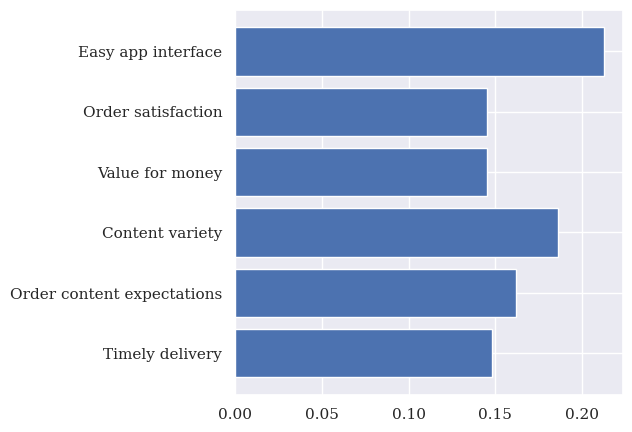

In [29]:
feats_xgb = best_xgb_model.feature_importances_
features = X_data.columns

plt.figure(figsize=(5,5))
plt.barh(y=features, width=feats_xgb)
plt.show()

Fitting 2 folds for each of 200 candidates, totalling 400 fits
The training set score for cv = 2 is: 0.69
The difference between train and CV score for cv = 2 is: 0.06

Fitting 4 folds for each of 200 candidates, totalling 800 fits
The training set score for cv = 4 is: 0.71
The difference between train and CV score for cv = 4 is: 0.08

Fitting 6 folds for each of 200 candidates, totalling 1200 fits
The training set score for cv = 6 is: 0.8
The difference between train and CV score for cv = 6 is: 0.14

Fitting 8 folds for each of 200 candidates, totalling 1600 fits
The training set score for cv = 8 is: 0.7
The difference between train and CV score for cv = 8 is: 0.07

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
The training set score for cv = 10 is: 0.97
The difference between train and CV score for cv = 10 is: 0.3

Fitting 12 folds for each of 200 candidates, totalling 2400 fits
The training set score for cv = 12 is: 0.97
The difference between train and CV score f

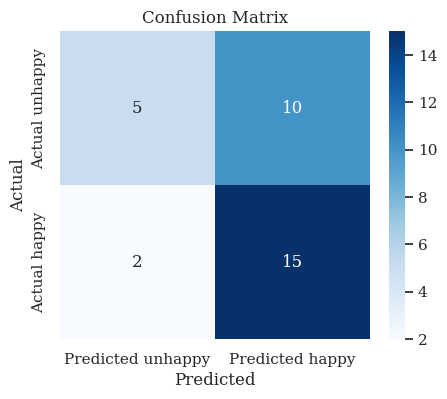

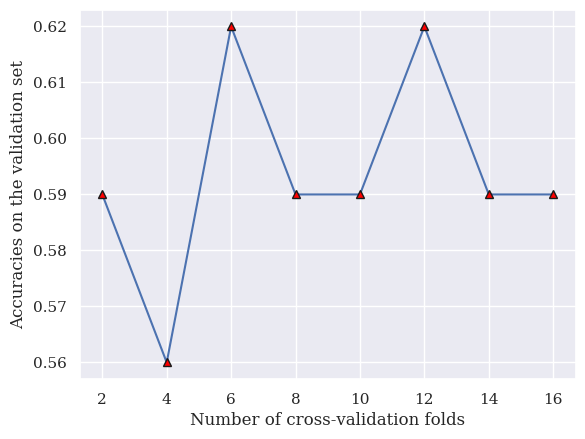

In [21]:
### As our next effort, we are going to try the SVC model after hyperparameter tuning
from sklearn.svm import SVC
from scipy.stats import uniform

sv_classifier = SVC(random_state=28)

parameter_grid = {
    'C' : loguniform(1e-4, 1e2),
    'kernel': ['linear', 'rbf','poly'],
    'degree':[2,3,4],
    'gamma':['auto','scale'],
    'class_weight':['balanced']
}

best_svc_model = model_investigation(sv_classifier, parameter_grid, x_train_scaled, y_train, x_val_scaled, y_val, 200)

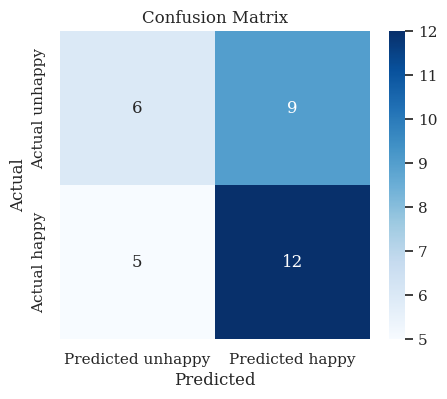

The associated accuracy score is: 0.56
The associated precision score is: 0.71
The associated recall score is: 0.57
The associated f1 score is: 0.63



In [22]:
from sklearn.ensemble import StackingClassifier

base_classifiers = [
    ('svc', best_svc_model),
    ('lr',best_logreg_model),
    ('xgb',best_xgb_model)]

stacking_classifier = StackingClassifier(estimators=base_classifiers,
                                        final_estimator = best_logreg_model,
                                         cv=5,
                                         passthrough=True)

stacking_classifier.fit(x_train_scaled, y_train)

y_pred = stacking_classifier.predict(x_val_scaled)
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted unhappy', 'Predicted happy'],
            yticklabels=['Actual unhappy', 'Actual happy'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(f'The associated accuracy score is: {round(accuracy_score(y_pred, y_val),2)}')
print(f'The associated precision score is: {round(precision_score(y_pred, y_val),2)}')
print(f'The associated recall score is: {round(recall_score(y_pred, y_val),2)}')
print(f'The associated f1 score is: {round(f1_score(y_pred, y_val),2)}\n')

In [30]:
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Simple neural network function
def create_model(neurons=32, learning_rate=0.01):
    model = keras.Sequential([
        keras.layers.Dense(neurons, activation='relu', input_shape=(6,)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(neurons, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

model = KerasClassifier(model=create_model, verbose=0)

param_grid = {
    'model__neurons': [16, 32, 64],
    'model__learning_rate': [0.001, 0.01, 0.1],
    #'epochs': [50, 100, 70]
}

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, verbose=0)]
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(x_train_scaled, y_train, batch_size=32, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)

print(f"Best score: {grid_search.best_score_:.3f}")
print(f"Best params: {grid_search.best_params_}")

test_score = grid_search.best_estimator_.score(x_val_scaled, y_val)
print(f"Test accuracy: {test_score:.3f}")

Best score: 0.596
Best params: {'model__learning_rate': 0.1, 'model__neurons': 16}
Test accuracy: 0.531


In [31]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(
grid_search.best_estimator_, x_val_scaled, y_val,
n_repeats=10,
random_state=42,
scoring='accuracy')

In [32]:
feature_importance_df = pd.DataFrame({
    'feature':X_data.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

In [33]:
feature_importance_df

,feature,importance_mean,importance_std
3,Value for money,0.034375,0.016829
4,Order satisfaction,0.009375,0.039652
0,Timely delivery,0.003125,0.016829
1,Order content expectations,-0.003125,0.016829
2,Content variety,-0.003125,0.009375
5,Easy app interface,-0.018750,0.020729


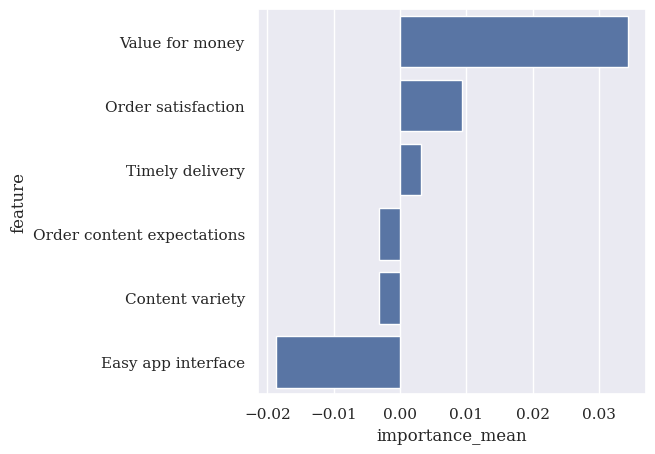

In [34]:
plt.figure(figsize=(5,5))
sns.barplot(x='importance_mean', y='feature', data=feature_importance_df)
plt.show()